## ReactionDiffusion 2D big
    - noise_lv = 10
    - Chk with bruteforcing
    - V2 means เอา Odd indices -> Look at issub variable | Odd or even not different
    - Choose even

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

Populating the interactive namespace from numpy and matplotlib


In [2]:
def nonzero(wei):
    return tuple(np.nonzero(wei)[0])

def check_percent(bic_scores, complexities):
    slope = (bic_scores[1:]-bic_scores[:-1])/(complexities[1:]-complexities[:-1])
    slope_index = np.argmin(slope)
    percent_improve = 100*np.abs(bic_scores[slope_index+1]-bic_scores[slope_index])/np.abs(bic_scores[slope_index])
    percent_from_1 = 100*np.abs(bic_scores[slope_index+1]-bic_scores[0])/np.abs(bic_scores[0])
    return slope_index+1, percent_improve, percent_from_1

def percent_coeff(pred, ground):
    return 100*(np.abs(pred-ground)/np.abs(ground))

In [3]:
data = sio.loadmat('../Datasets/reaction_diffusion_2d_big.mat')
u_sol = real(data['u'])
v_sol = real(data['v'])
x = real(data['x'][0])
y = real(data['y'][0])
t = real(data['t'][:,0])

n = 512; issub = 2
if issub > 1:
    spatial_sub_indices = np.array([i for i in range(n) if i%issub==0])
    u_sol = u_sol[spatial_sub_indices, :, :][:, spatial_sub_indices, :]
    v_sol = v_sol[spatial_sub_indices, :, :][:, spatial_sub_indices, :]
    x = x[spatial_sub_indices]
    y = y[spatial_sub_indices]
m = 201; issub = 1
if issub > 1:
    time_sub_indices = np.array([i for i in range(m) if i%issub==0])
    u_sol = u_sol[:, :, time_sub_indices]
    v_sol = v_sol[:, :, time_sub_indices]
    t = t[time_sub_indices]

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

# For WeakPDELibrary
ground_indices_u = (0, 2, 3, 4, 5, 8, 14)
ground_coeff_u = np.array([1.000,-1.000,1.000,-1.000,1.000,0.100,0.100])
ground_indices_v = (1, 2, 3, 4, 5, 9, 15)
ground_coeff_v = np.array([1.000,-1.000,-1.000,-1.000,-1.000,0.100,0.100])

x, y, t

(array([-10.      ,  -9.921875,  -9.84375 ,  -9.765625,  -9.6875  ,
         -9.609375,  -9.53125 ,  -9.453125,  -9.375   ,  -9.296875,
         -9.21875 ,  -9.140625,  -9.0625  ,  -8.984375,  -8.90625 ,
         -8.828125,  -8.75    ,  -8.671875,  -8.59375 ,  -8.515625,
         -8.4375  ,  -8.359375,  -8.28125 ,  -8.203125,  -8.125   ,
         -8.046875,  -7.96875 ,  -7.890625,  -7.8125  ,  -7.734375,
         -7.65625 ,  -7.578125,  -7.5     ,  -7.421875,  -7.34375 ,
         -7.265625,  -7.1875  ,  -7.109375,  -7.03125 ,  -6.953125,
         -6.875   ,  -6.796875,  -6.71875 ,  -6.640625,  -6.5625  ,
         -6.484375,  -6.40625 ,  -6.328125,  -6.25    ,  -6.171875,
         -6.09375 ,  -6.015625,  -5.9375  ,  -5.859375,  -5.78125 ,
         -5.703125,  -5.625   ,  -5.546875,  -5.46875 ,  -5.390625,
         -5.3125  ,  -5.234375,  -5.15625 ,  -5.078125,  -5.      ,
         -4.921875,  -4.84375 ,  -4.765625,  -4.6875  ,  -4.609375,
         -4.53125 ,  -4.453125,  -4.375   ,  -4.

In [4]:
u = np.zeros((x.shape[0], y.shape[0], len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
np.random.seed(100)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])

In [5]:
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=10000,
    is_uniform=True,
    periodic=True,
    include_interaction=True, 
    cache=True
)

# Noiseless
u_noisy = u.copy()
noise_lv = 10
domain_noise = 0.01*np.abs(noise_lv)*np.std(u_noisy)*np.random.randn(u_noisy.shape[0], 
                                                                     u_noisy.shape[1], 
                                                                     u_noisy.shape[2], 
                                                                     u_noisy.shape[3],)
u_noisy = u_noisy + domain_noise

In [6]:
thres_stlsq = None
thres_stlsq = 1e-1
if thres_stlsq is not None:
    optimizer = ps.STLSQ(threshold=thres_stlsq, alpha=1e-5, normalize_columns=True)

# thres = 5e-4
# optimizer = L0BNB(max_nonzeros=12, lam=1e-1, threshold=thres, 
#                   is_normal=False, normalize_columns=True)

In [7]:
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, 
                 cache=True, feature_names=['u', 'v'])
model.fit(u_noisy, ensemble=False, library_ensemble=True)
model.print()

(u)' = 0.925 u + 0.089 v + -0.908 uuu + 0.885 vvv + -0.907 uvv + 0.884 uuv + 0.092 u_22 + 0.092 u_11
(v)' = -0.072 u + 0.927 v + -0.903 uuu + -0.909 vvv + -0.902 uvv + -0.909 uuv + 0.093 v_22 + 0.093 v_11 + 0.021 uu_1 + -0.055 uuuu_1 + 0.024 vvvv_1 + -0.059 uvvv_1


In [8]:
_, ensemble_indices_u = model.validate_coef_list(target_index=0, criterion='bic')[0]
ensemble_indices_u

hasattr threshold in optimizer...
u_t = (1.116216 +0.000000i)v
    + (-0.224636 +0.000000i)vvv
    + (-0.229177 +0.000000i)uuv
    + (0.035666 +0.000000i)vu_2
    + (0.096142 +0.000000i)vvvv_2
    + (-0.105192 +0.000000i)uvvv_2
    + (-0.067027 +0.000000i)uuvv_2
    + (0.170647 +0.000000i)uuuu_1
    + (-0.004728 +0.000000i)uuuv_1
    + (0.162896 +0.000000i)uvvv_1
    + (0.035666 +0.000000i)vu_12
    + (0.096142 +0.000000i)vvvv_12
    + (-0.105192 +0.000000i)uvvv_12
    + (-0.067027 +0.000000i)uuvv_12
   


(1, 3, 5, 18, 23, 25, 27, 44, 45, 49, 54, 59, 61, 63)

In [9]:
_, ensemble_indices_v = model.validate_coef_list(target_index=1, criterion='bic')[0]
ensemble_indices_v

hasattr threshold in optimizer...
v_t = (-1.095235 +0.000000i)u
    + (0.037481 +0.000000i)v
    + (0.202635 +0.000000i)uuu
    + (-0.042534 +0.000000i)vvv
    + (0.204674 +0.000000i)uvv
    + (-0.040538 +0.000000i)uuv
   


(0, 1, 2, 3, 4, 5)

In [10]:
# pub
# stridge_u ...
# {(0, 1, 2, 3, 4, 5)}
# {(0, 1, 2, 3, 4, 5, 8, 14), (0, 1, 2, 3, 4, 5), (0, 1, 3, 5, 8, 9, 14, 15, 16, 18, 20, 23, 25, 27, 40, 42, 44, 47, 52, 54, 56, 59, 61, 63)}
# stridge_v ...
# {(0, 1, 2, 3, 4, 5)}
# {(0, 1, 2, 3, 4, 5, 9, 15, 35, 37, 39, 71, 73, 75), (0, 1, 3, 5, 8, 9, 14, 15, 40, 44, 45, 46, 47, 48, 49), (0, 1, 2, 3, 4, 5), (0, 1, 2, 3, 4, 5, 9, 15, 40, 44, 47, 49), (0, 1, 2, 3, 4, 5, 9, 15, 35, 37, 39, 40, 44, 47, 49, 71, 73, 75)}

print("stridge_u ...")
stridge_u = set()
stridge_u.add(ensemble_indices_u)
print(stridge_u)
for i in range(len(model.get_coef_list())):
    stridge_u.add(nonzero(model.get_coef_list()[i][0]))
print(stridge_u)

print("stridge_v ...")
stridge_v = set()
stridge_v.add(ensemble_indices_v)
print(stridge_v)
for i in range(len(model.get_coef_list())):
    stridge_v.add(nonzero(model.get_coef_list()[i][1]))
print(stridge_v)

stridge_u ...
{(1, 3, 5, 18, 23, 25, 27, 44, 45, 49, 54, 59, 61, 63)}
{(0, 1, 2, 3, 4, 5, 8, 14), (1, 3, 5, 18, 23, 25, 27, 44, 45, 49, 54, 59, 61, 63), (0, 1, 3, 5, 8, 9, 14, 15, 16, 18, 20, 23, 25, 27, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 56, 59, 61, 63)}
stridge_v ...
{(0, 1, 2, 3, 4, 5)}
{(0, 1, 2, 3, 4, 5, 9, 15), (0, 1, 2, 3, 4, 5), (0, 1, 3, 5, 8, 9, 14, 15, 40, 44, 45, 46, 47, 48, 49, 50), (0, 1, 2, 3, 4, 5, 9, 15, 40, 44, 47, 49)}


In [11]:
X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot
# nonzero(brute_force(X_pre[:, :16], y_pre[:, 0:1], support_size=7))
# nonzero(brute_force(X_pre[:, :16], y_pre[:, 1:2], support_size=7))

In [12]:
max_complexity = 12; target_index = 1

In [13]:
# pub
# {(0,),
#  (0, 2, 3, 4, 5, 8, 9, 14, 15),
#  (0, 2, 4),
#  (0, 2, 4, 8, 9, 14, 15),
#  (0, 2, 4, 8, 14)}

thres = 1e-4
nor_axis = None
if nor_axis is not None: Xbnb = normalize(X_pre, axis=nor_axis)
else: Xbnb = X_pre.copy()
bnb_feature_hierarchy = set()
for lam in (1e-1, ): # (1e-1, ) and (1e-2, ) are fine.
    bnb_sols = bnb(Xbnb, y_pre[:, target_index:target_index+1].ravel(), max_nonzeros=max_complexity, 
                   lam=lam, threshold=thres, normalize=True, corrected_coefficients=True)
    bnb_feature_hierarchy = bnb_feature_hierarchy.union(set([tuple(np.nonzero(bnb_sols[:, i:i+1].flatten())[0].tolist()) 
                                                             for i in range(bnb_sols.shape[1])]))
bnb_feature_hierarchy

{(0,),
 (0, 2, 3, 4, 5, 8, 9, 14, 15),
 (0, 2, 4),
 (0, 2, 4, 8, 9, 14, 15),
 (0, 2, 4, 8, 14)}

In [14]:
nor_axis = 0
if nor_axis is not None: Xfrols = normalize(X_pre, axis=nor_axis)
else: Xfrols = X_pre.copy()
frols_coeffs,selected_inds_list,_,_,_ = frols(y_pre[:, target_index:target_index+1], Xfrols, max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
selected_inds_list

{(0,),
 (0, 1, 2, 3, 4, 5, 8, 9, 12, 14, 15, 72),
 (0, 1, 2, 3, 4, 5, 8, 9, 14, 15),
 (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 72),
 (0, 1, 2, 3, 4, 8, 9, 14, 15),
 (0, 1, 2, 4, 8, 9, 14, 15),
 (0, 1, 2, 8, 9, 14, 15),
 (0, 1, 8, 9, 14, 15),
 (0, 1, 8, 9, 15),
 (0, 1, 9, 15),
 (0, 1, 15),
 (0, 15)}

In [15]:
feature_hierarchy_u = bnb_feature_hierarchy.union(selected_inds_list)
if thres_stlsq is not None:
    if target_index == 0:
        feature_hierarchy_u = stridge_u.union((bnb_feature_hierarchy).union(selected_inds_list))
    elif target_index == 1:
        feature_hierarchy_u = stridge_v.union((bnb_feature_hierarchy).union(selected_inds_list))

In [16]:
br1 = backward_refinement(feature_hierarchy_u, (X_pre,y_pre[:, target_index:target_index+1]), mode='rfe', ic_type='bic', verbose=True)
br2 = backward_refinement(feature_hierarchy_u, (X_pre,y_pre[:, target_index:target_index+1]), mode='k best', ic_type='bic', verbose=True)
br_u=br1+br2; br_u

RFE_PLinearRegression
(0, 2, 4, 8, 9, 14, 15)
(0, 4, 8, 9, 14, 15)
(0, 8, 9, 14, 15)
(0, 8, 9, 15)
(0, 9, 15)
(0, 15)
(0,)
--------------------------------------------------
(0, 2, 3, 4, 5, 8, 9, 14, 15)
(2, 3, 4, 5, 8, 9, 14, 15)
(2, 3, 4, 8, 9, 14, 15)
(2, 3, 4, 8, 9, 15)
(2, 3, 4, 9, 15)
(2, 3, 4, 15)
(2, 4, 15)
(2, 4)
(2,)
--------------------------------------------------
(0, 1, 2, 3, 4, 5)
(0, 1, 2, 3, 4)
(0, 2, 3, 4)
(0, 2, 4)
(0, 4)
(0,)
--------------------------------------------------
(0, 1, 9, 15)
(0, 1, 15)
(0, 15)
--------------------------------------------------
(0, 1, 8, 9, 15)
(0, 1, 9, 15)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 9, 15)
(1, 2, 3, 4, 5, 9, 15)
(1, 2, 3, 4, 9, 15)
(1, 2, 4, 9, 15)
(1, 2, 4, 15)
(2, 4, 15)
--------------------------------------------------
(0, 1, 2, 3, 4, 8, 9, 14, 15)
(1, 2, 3, 4, 8, 9, 14, 15)
(1, 2, 4, 8, 9, 14, 15)
(1, 2, 4, 8, 9, 15)
(1, 2, 4, 9, 15)
--------------------------------------------------
(0

{1: ((0,), -81052.22353512596), 2: ((0, 15), -81641.44945432483), 3: ((0, 1, 15), -82087.9246051103), 4: ((0, 1, 9, 15), -84942.90814447866), 5: ((0, 1, 8, 9, 15), -85059.02116729894), 6: ((0, 1, 3, 5, 9, 15), -87460.27140206804), 7: ((1, 2, 3, 4, 5, 9, 15), -96686.89941438766), 8: ((0, 1, 2, 3, 4, 5, 9, 15), -96781.03306804631), 9: ((0, 1, 2, 3, 4, 5, 9, 15, 72), -96776.19903183915), 10: ((0, 1, 2, 3, 4, 5, 9, 14, 15, 72), -96770.82241522834), 11: ((0, 1, 2, 3, 4, 5, 9, 12, 14, 15, 72), -96764.59785187413), 12: ((0, 1, 2, 3, 4, 5, 8, 9, 12, 14, 15, 72), -96756.7258745426), 13: ((0, 1, 3, 5, 8, 9, 14, 15, 40, 44, 45, 47, 49), -89669.54823138031), 14: ((0, 1, 3, 5, 8, 9, 14, 15, 40, 44, 45, 47, 48, 49), -89660.70330942146), 15: ((0, 1, 3, 5, 8, 9, 14, 15, 40, 44, 45, 46, 47, 48, 49), -89685.23406961319), 16: ((0, 1, 3, 5, 8, 9, 14, 15, 40, 44, 45, 46, 47, 48, 49, 50), -89685.60285836444)}

In [17]:
print("Ploting less than max_complexity")
for c in range(max_complexity+1, max(list(br_u.track.keys()))+1):
    del_c = br_u.delete(c)
    if del_c is not None: print(f"Delete {c} complexity")
    else: print(f"{c} not exist")

Ploting less than max_complexity
Delete 13 complexity
Delete 14 complexity
Delete 15 complexity
Delete 16 complexity


In [18]:
# For reproducibility of 2% noise experiment
# u
# (1,) -90432.11492322256
# (1, 14) -90900.56314841735
# (0, 1, 14) -91096.59801155927
# (0, 1, 8, 14) -92631.07213881976
# (0, 1, 8, 14, 15) -92711.06074776711
# (0, 1, 8, 9, 14, 15) -92912.16926463085
# (0, 2, 3, 4, 5, 8, 14) -99273.17863634705
# (0, 1, 2, 3, 4, 5, 8, 14) -99629.82290987358
# (0, 1, 2, 3, 4, 5, 8, 14, 67) -99627.38471701351
# (0, 1, 2, 3, 4, 5, 8, 14, 67, 72) -99626.97018095759
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 67, 72) -99619.72292591527
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 67, 72) -99611.13907227767
# + stlsq before
# (1,) -90432.11492322256
# (1, 14) -90900.56314841735
# (0, 1, 14) -91096.59801155927
# (0, 1, 8, 14) -92631.07213881976
# (0, 1, 8, 14, 15) -92711.06074776711
# (0, 1, 2, 4, 8, 14) -94460.72867681735
# (0, 2, 3, 4, 5, 8, 14) -99273.17863634705
# (0, 1, 2, 3, 4, 5, 8, 14) -99629.82290987358
# (0, 1, 2, 3, 4, 5, 8, 14, 67) -99627.38471701351
# (0, 1, 2, 3, 4, 5, 8, 14, 67, 72) -99626.97018095759
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 67, 72) -99619.72292591527
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 67, 72) -99611.13907227767

# v
# (0,) -89704.75044145095
# (0, 15) -90094.80085394751
# (0, 1, 15) -90433.5949355086
# (0, 1, 9, 15) -92311.22556061689
# (0, 1, 8, 9, 15) -92462.0683253755
# (0, 1, 3, 5, 9, 15) -94229.07163281288
# (1, 2, 3, 4, 5, 9, 15) -98884.21234254984
# (0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
# (0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
# (0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259
# + stlsq before
# (0,) -89704.75044145095
# (0, 15) -90094.80085394751
# (0, 1, 15) -90433.5949355086
# (0, 1, 9, 15) -92311.22556061689
# (0, 1, 8, 9, 15) -92462.0683253755
# (0, 1, 3, 5, 9, 15) -94229.07163281288
# (1, 2, 3, 4, 5, 9, 15) -98884.21234254984
# (0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
# (0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
# (0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259

complexities = np.array(sorted(list(br_u.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br_u.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(0,) -81052.22353512596
(0, 15) -81641.44945432483
(0, 1, 15) -82087.9246051103
(0, 1, 9, 15) -84942.90814447866
(0, 1, 8, 9, 15) -85059.02116729894
(0, 1, 3, 5, 9, 15) -87460.27140206804
(1, 2, 3, 4, 5, 9, 15) -96686.89941438766
(0, 1, 2, 3, 4, 5, 9, 15) -96781.03306804631
(0, 1, 2, 3, 4, 5, 9, 15, 72) -96776.19903183915
(0, 1, 2, 3, 4, 5, 9, 14, 15, 72) -96770.82241522834
(0, 1, 2, 3, 4, 5, 9, 12, 14, 15, 72) -96764.59785187413
(0, 1, 2, 3, 4, 5, 8, 9, 12, 14, 15, 72) -96756.7258745426


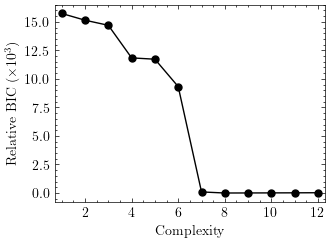

In [19]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot(complexities, rel_bic_scores, color='black', linewidth=2.5//2)
    ax.scatter(complexities, rel_bic_scores, marker='o', c='black', s=25)
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)")
    plt.xlabel("Complexity")
    plt.tight_layout()
    plt.show()

In [20]:
optimal_slope_index, im1, im2 = check_percent(bic_scores, complexities)
optimal_slope_index, im1, im2

(6, 10.549507638620764, 19.289632285641165)

In [21]:
if target_index == 0: 
    ground = ground_coeff_u
    ground_indices = ground_indices_u
elif target_index ==1 : 
    ground = ground_coeff_v
    ground_indices = ground_indices_v
correctly_discover = False
if br_u.track[optimal_slope_index+1][0] == ground_indices: 
    correctly_discover = True
    print("Correctly discover?", correctly_discover)
pred = np.linalg.lstsq(X_pre[:, br_u.track[optimal_slope_index+1][0]], 
                       y_pre[:, target_index:target_index+1], rcond=None)[0].flatten()
errs = percent_coeff(pred, ground)
errs.mean(), errs.std()

Correctly discover? True


(3.3250884079139156, 1.2489754144067837)

In [25]:
metric_dict = {'rel_bic_scores': rel_bic_scores, 
               'complexities': complexities, 
               'min_bic_score': min_bic_score, 
               'found_coeff': pred, 
               'percent_coefficient_error_mean': errs.mean(), 
               'percent_coefficient_error_std': errs.std()}
metric_dict

{'rel_bic_scores': array([1.57288095e+01, 1.51395836e+01, 1.46931085e+01, 1.18381249e+01,
        1.17220119e+01, 9.32076167e+00, 9.41336537e-02, 0.00000000e+00,
        4.83403621e-03, 1.02106528e-02, 1.64352162e-02, 2.43071935e-02]),
 'complexities': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'min_bic_score': -96781.03306804631,
 'found_coeff': array([ 0.9674894 , -0.98136438, -0.94840587, -0.97988654, -0.9486549 ,
         0.09729326,  0.09685101]),
 'percent_coefficient_error_mean': 3.3250884079139156,
 'percent_coefficient_error_std': 1.2489754144067837}

In [26]:
if correctly_discover:
    target_index2name = ['u', 'v']
    file_name = f"./Visualization/reaction_diffustion_2d_big_{target_index2name[target_index]}_stlsq_bnb_frols_noise_lv{noise_lv}.mat"
    print(file_name)
    # sio.savemat(file_name, metric_dict)

./Visualization/reaction_diffustion_2d_big_v_stlsq_bnb_frols_noise_lv10.mat


In [27]:
all_possible_candidates = sorted(set().union(*[br_u.track[mc][0] for mc in br_u.track.keys()]))
out = np.hstack([brute_force(X_pre[:, all_possible_candidates], y_pre[:, target_index:target_index+1], 
                             support_size=i+1) for i in range(len(all_possible_candidates))]).T
for i in range(len(out)):
    print(tuple(np.array(all_possible_candidates)[list(nonzero(out[i]))]))

(0,)
(0, 15)
(0, 1, 15)
(0, 1, 9, 15)
(0, 1, 8, 9, 15)
(0, 1, 3, 5, 9, 15)
(1, 2, 3, 4, 5, 9, 15)
(0, 1, 2, 3, 4, 5, 9, 15)
(0, 1, 2, 3, 4, 5, 9, 15, 72)
(0, 1, 2, 3, 4, 5, 9, 14, 15, 72)
(0, 1, 2, 3, 4, 5, 9, 12, 14, 15, 72)
(0, 1, 2, 3, 4, 5, 8, 9, 12, 14, 15, 72)


In [28]:
feature_hierarchy = set(tuple(np.array(all_possible_candidates)[list(nonzero(out[i]))]) for i in range(len(out)))

In [29]:
br1 = backward_refinement(feature_hierarchy, (X_pre,y_pre[:, target_index:target_index+1]), mode='rfe', ic_type='bic', verbose=True)
br2 = backward_refinement(feature_hierarchy, (X_pre,y_pre[:, target_index:target_index+1]), mode='k best', ic_type='bic', verbose=True)
br=br1+br2; br

RFE_PLinearRegression
(1, 2, 3, 4, 5, 9, 15)
(1, 2, 3, 4, 9, 15)
(1, 2, 4, 9, 15)
(1, 2, 4, 15)
(2, 4, 15)
(2, 4)
(2,)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 9, 15, 72)
(0, 1, 2, 3, 4, 5, 9, 15)
(1, 2, 3, 4, 5, 9, 15)
--------------------------------------------------
(0, 15)
(0,)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 9, 12, 14, 15, 72)
(0, 1, 2, 3, 4, 5, 9, 14, 15, 72)
(0, 1, 2, 3, 4, 5, 9, 15, 72)
--------------------------------------------------
(0, 1, 3, 5, 9, 15)
(0, 1, 3, 9, 15)
(0, 1, 9, 15)
(0, 1, 15)
(0, 15)
--------------------------------------------------
(0, 1, 15)
--------------------------------------------------
(0, 1, 9, 15)
--------------------------------------------------
(0, 1, 8, 9, 15)
(0, 1, 9, 15)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 9, 15)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 8, 9, 12, 14, 15, 72)
(0, 1, 2, 3, 4, 5, 9, 12, 14, 15, 7

{1: ((0,), -81052.22353512596), 2: ((0, 15), -81641.44945432483), 3: ((0, 1, 15), -82087.9246051103), 4: ((0, 1, 9, 15), -84942.90814447866), 5: ((0, 1, 8, 9, 15), -85059.02116729894), 6: ((0, 1, 3, 5, 9, 15), -87460.27140206804), 7: ((1, 2, 3, 4, 5, 9, 15), -96686.89941438766), 8: ((0, 1, 2, 3, 4, 5, 9, 15), -96781.03306804631), 9: ((0, 1, 2, 3, 4, 5, 9, 15, 72), -96776.19903183915), 10: ((0, 1, 2, 3, 4, 5, 9, 14, 15, 72), -96770.82241522834), 11: ((0, 1, 2, 3, 4, 5, 9, 12, 14, 15, 72), -96764.59785187413), 12: ((0, 1, 2, 3, 4, 5, 8, 9, 12, 14, 15, 72), -96756.7258745426)}

In [30]:
print("Ploting less than max_complexity")
for c in range(max_complexity+1, max(list(br.track.keys()))+1):
    del_c = br.delete(c)
    if del_c is not None: print(f"Delete {c} complexity")
    else: print(f"{c} not exist")

Ploting less than max_complexity


In [31]:
# For reproducibility of 2% noise experiment
# u
# (1,) -90432.11492322256
# (1, 14) -90900.56314841735
# (0, 1, 14) -91096.59801155927
# (0, 1, 8, 14) -92631.07213881976
# (0, 1, 8, 14, 15) -92711.06074776711
# (0, 1, 2, 4, 8, 14) -94460.72867681735
# (0, 2, 3, 4, 5, 8, 14) -99273.17863634705
# (0, 1, 2, 3, 4, 5, 8, 14) -99629.82290987358
# (0, 1, 2, 3, 4, 5, 8, 14, 67) -99627.38471701351
# (0, 1, 2, 3, 4, 5, 8, 14, 67, 72) -99626.97018095759
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 67, 72) -99619.72292591527
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 67, 72) -99611.13907227767
# + stlsq before
# (1,) -90432.11492322256
# (1, 14) -90900.56314841735
# (0, 1, 14) -91096.59801155927
# (0, 1, 8, 14) -92631.07213881976
# (0, 1, 8, 14, 15) -92711.06074776711
# (0, 1, 2, 4, 8, 14) -94460.72867681735
# (0, 2, 3, 4, 5, 8, 14) -99273.17863634705
# (0, 1, 2, 3, 4, 5, 8, 14) -99629.82290987358
# (0, 1, 2, 3, 4, 5, 8, 14, 67) -99627.38471701351
# (0, 1, 2, 3, 4, 5, 8, 14, 67, 72) -99626.97018095759
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 67, 72) -99619.72292591527
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 67, 72) -99611.13907227767

# v
# (0,) -89704.75044145095
# (0, 15) -90094.80085394751
# (0, 1, 15) -90433.5949355086
# (0, 1, 9, 15) -92311.22556061689
# (0, 1, 8, 9, 15) -92462.0683253755
# (0, 1, 3, 5, 9, 15) -94229.07163281288
# (1, 2, 3, 4, 5, 9, 15) -98884.21234254984
# (0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
# (0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
# (0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259
# + stlsq before
# (0,) -89704.75044145095
# (0, 15) -90094.80085394751
# (0, 1, 15) -90433.5949355086
# (0, 1, 9, 15) -92311.22556061689
# (0, 1, 8, 9, 15) -92462.0683253755
# (0, 1, 3, 5, 9, 15) -94229.07163281288
# (1, 2, 3, 4, 5, 9, 15) -98884.21234254984
# (0, 1, 2, 3, 4, 5, 9, 15) -99223.00785465668
# (0, 1, 2, 3, 4, 5, 9, 14, 15) -99226.63012262661
# (0, 1, 2, 3, 4, 5, 9, 14, 15, 69) -99230.05524578446
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69) -99224.97738853545
# (0, 1, 2, 3, 4, 5, 8, 9, 14, 15, 69, 72) -99216.5636109259

complexities = np.array(sorted(list(br.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(0,) -81052.22353512596
(0, 15) -81641.44945432483
(0, 1, 15) -82087.9246051103
(0, 1, 9, 15) -84942.90814447866
(0, 1, 8, 9, 15) -85059.02116729894
(0, 1, 3, 5, 9, 15) -87460.27140206804
(1, 2, 3, 4, 5, 9, 15) -96686.89941438766
(0, 1, 2, 3, 4, 5, 9, 15) -96781.03306804631
(0, 1, 2, 3, 4, 5, 9, 15, 72) -96776.19903183915
(0, 1, 2, 3, 4, 5, 9, 14, 15, 72) -96770.82241522834
(0, 1, 2, 3, 4, 5, 9, 12, 14, 15, 72) -96764.59785187413
(0, 1, 2, 3, 4, 5, 8, 9, 12, 14, 15, 72) -96756.7258745426


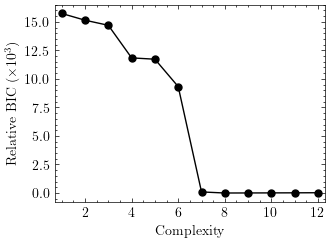

In [32]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot(complexities, rel_bic_scores, color='black', linewidth=2.5//2)
    ax.scatter(complexities, rel_bic_scores, marker='o', c='black', s=25)
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)")
    plt.xlabel("Complexity")
    plt.tight_layout()
    plt.show()

In [33]:
check_percent(bic_scores, complexities)

(6, 10.549507638620764, 19.289632285641165)

In [34]:
metric_dict = {'rel_bic_scores': rel_bic_scores, 
               'complexities': complexities, 
               'min_bic_score': min_bic_score, 
               'found_coeff': pred, 
               'percent_coefficient_error_mean': errs.mean(), 
               'percent_coefficient_error_std': errs.std()}
metric_dict

{'rel_bic_scores': array([1.57288095e+01, 1.51395836e+01, 1.46931085e+01, 1.18381249e+01,
        1.17220119e+01, 9.32076167e+00, 9.41336537e-02, 0.00000000e+00,
        4.83403621e-03, 1.02106528e-02, 1.64352162e-02, 2.43071935e-02]),
 'complexities': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'min_bic_score': -96781.03306804631,
 'found_coeff': array([ 0.9674894 , -0.98136438, -0.94840587, -0.97988654, -0.9486549 ,
         0.09729326,  0.09685101]),
 'percent_coefficient_error_mean': 3.3250884079139156,
 'percent_coefficient_error_std': 1.2489754144067837}

In [35]:
if correctly_discover:
    target_index2name = ['u', 'v']
    file_name = f"./Visualization/reaction_diffustion_2d_big_{target_index2name[target_index]}_stlsq_bnb_frols_bruteforce_noise_lv{noise_lv}.mat"
    print(file_name)
    # sio.savemat(file_name, metric_dict)

./Visualization/reaction_diffustion_2d_big_v_stlsq_bnb_frols_bruteforce_noise_lv10.mat


In [36]:
d_bic_scores, d_complexities, _ = get_decreasing_vals(bic_scores, complexities)

In [37]:
# also tested with percent_ok = 0.09
find_transition_V2(d_bic_scores, d_complexities, 0.09)

7 improves 1
Percent improve: 0.19289632285641164
8 does not improve 7
Percent improve: 0.000973592640045278


7